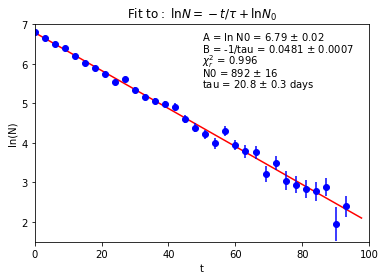

In [1]:
# código original do autor. Ver minhas alterações na próxima célula.

import numpy as np
import matplotlib.pyplot as plt


def LineFitWt(x, y, sig):
    """ 
    Returns slope and y-intercept of weighted linear fit to (x,y) data set.
    Inputs: x and y data array and uncertainty array (unc) for y data set.
    Ouputs: slope and y-intercept of best fit to data.
    """
    sig2 = sig**2
    norm = (1. / sig2).sum()
    xhat = (x / sig2).sum() / norm
    yhat = (y / sig2).sum() / norm
    slope = ((x - xhat) * y / sig2).sum() / ((x - xhat) * x / sig2).sum()
    yint = yhat - slope * xhat
    sig2_slope = 1. / ((x - xhat) * x / sig2).sum()
    sig2_yint = sig2_slope * (x * x / sig2).sum() / norm
    return slope, yint, np.sqrt(sig2_slope), np.sqrt(sig2_yint)


def redchisq(x, y, dy, slope, yint):
    chisq = (((y - yint - slope * x) / dy)**2).sum()
    return chisq / float(x.size - 2)


# Read data from data file
t, N, dN = np.loadtxt("betaDecay.txt", skiprows=2, unpack=True)

########## Code to tranform & fit data starts here ##########

# Transform data and parameters to linear form: Y = A + B*X
X = t  # transform t data for fitting (not necessary since X=t)
Y = np.log(N)  # transform N data for fitting
dY = dN / N  # transform uncertainties for fitting

# Fit transformed data X, Y, dY to obtain fitting parameters A & B
# Also returns uncertainties in A and B
B, A, dB, dA = LineFitWt(X, Y, dY)
# Return reduced chi-squared
redchisqr = redchisq(X, Y, dY, B, A)

# Determine fitting parameters for original exponential function
# N = N0 exp(-t/tau) ...
N0 = np.exp(A)
tau = -1.0 / B
# ... and their uncertainties
dN0 = N0 * dA
dtau = tau**2 * dB

########## Code to plot transformed data and fit starts here ##########

# Create line corresponding to fit using fitting parameters
# Only two points are needed to specify a straight line
Xext = 0.05 * (X.max() - X.min())
Xfit = np.array([X.min() - Xext,
                 X.max() + Xext])  # smallest & largest X points
Yfit = A + B * Xfit  # generates Y from X data & fitting function

plt.errorbar(X, Y, dY, fmt="bo")
plt.plot(Xfit, Yfit, "r-", zorder=-1)
plt.xlim(0, 100)
plt.ylim(1.5, 7)
plt.title("$\mathrm{Fit\\ to:}\\ \ln N = -t/\\tau + \ln N_0$")
plt.xlabel("t")
plt.ylabel("ln(N)")

plt.text(50, 6.6, "A = ln N0 = {0:0.2f} $\pm$ {1:0.2f}".format(A, dA))
plt.text(50, 6.3, "B = -1/tau = {0:0.4f} $\pm$ {1:0.4f}".format(-B, dB))
plt.text(50, 6.0, "$\chi_r^2$ = {0:0.3f}".format(redchisqr))

plt.text(50, 5.7, "N0 = {0:0.0f} $\pm$ {1:0.0f}".format(N0, dN0))
plt.text(50, 5.4, "tau = {0:0.1f} $\pm$ {1:0.1f} days".format(tau, dtau))

plt.savefig("betaDecay.pdf")
plt.show()

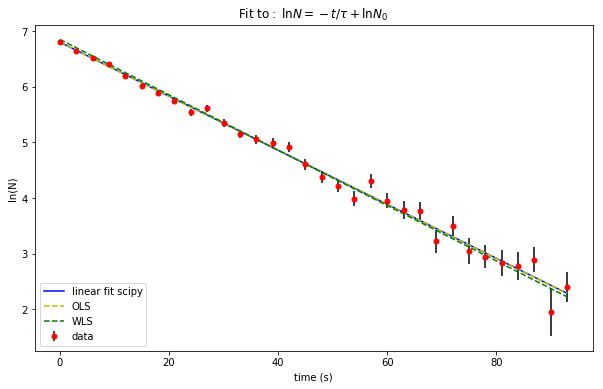

##############################################################################################
                          Linear regression with Scipy Results
Slope: -0.0486060042739
Intercept: 6.8037091942
R: -0.994141627982
R2: 0.988317576486
P: 1.49674091694e-30
Std err slope: 0.000964822687105

###############################################################################################
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2538.
Date:                Wed, 07 Feb 2018   Prob (F-statistic):           1.50e-30
Time:                        21:40:53   Log-Likelihood:                 16.084
No. Observations:                  32   AIC:                            -28.17
Df Residuals:                      30   BIC:        

In [17]:
#refazendo o programa acima usando funções prontas para cuidar das incertezas e do fit

import numpy as np
import matplotlib.pyplot as plt
import uncertainties as u
from uncertainties import unumpy
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Read data from data file
t, N, dN = np.loadtxt("betaDecay.txt", skiprows=2, unpack=True)

#utilizando o package uncertainties para juntar o dado de N com sua incerteza
N_u = unumpy.uarray(N, dN)

# Transform data and parameters to linear form: Y = A + B*X
x = t  # transform t data for fitting (not necessary since X=t)
y = unumpy.log(N_u)  # transform N data for fitting

#isolando os valores de erros para a ordenada após linearização
y_err = unumpy.std_devs(y)

#fit scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(
    x, unumpy.nominal_values(y))

#fit statsmodel OLS
#time = sm.add_constant(time)
#X = np.column_stack((time,vel))
X = sm.add_constant(x)
fit_ols = sm.OLS(unumpy.nominal_values(y), X).fit()

#fit statsmodel WLS
fit_wls = sm.WLS(unumpy.nominal_values(y), X, weights=y_err).fit()

# create plot
plt.figure(1, figsize=(10, 6))

plt.errorbar(x,
             unumpy.nominal_values(y),
             fmt='ro',
             label="data",
             yerr=y_err,
             markersize=5,
             ecolor='black')

plt.plot(x, intercept + slope * x, 'b-', label="linear fit scipy")

plt.plot(x, fit_ols.fittedvalues, 'y--', label="OLS")

plt.plot(x, fit_wls.fittedvalues, 'g--', label="WLS")

plt.title("$\mathrm{Fit\\ to:}\\ \ln N = -t/\\tau + \ln N_0$")

plt.ylabel('ln(N)')
plt.xlabel('time (s)')
plt.legend(loc='lower left')

plt.show()

print(
    '##############################################################################################'
)
print('                          Linear regression with Scipy Results')
print('Slope:', slope)
print('Intercept:', intercept)
print('R:', r_value)
print('R2:', r_value**2)
print('P:', p_value)
print('Std err slope:', std_err)

print(
    '\n###############################################################################################'
)
print(fit_ols.summary())
print(
    '\n###############################################################################################'
)
print(fit_wls.summary())

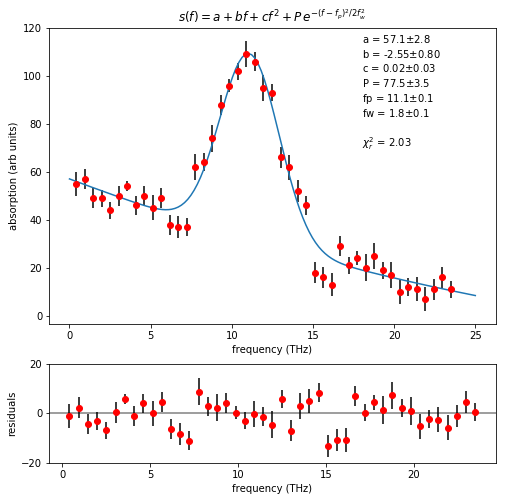

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # for unequal plot boxes
import scipy.optimize


# define fitting function
def GaussPolyBase(f, a, b, c, P, fp, fw):
    return a + b * f + c * f * f + P * np.exp(-0.5 * ((f - fp) / fw)**2)


# read in spectrum from data file
# f=frequency, s=signal, ds=s uncertainty
f, s, ds = np.loadtxt("Spectrum.txt", skiprows=4, unpack=True)

# initial guesses for fitting parameters
a0, b0, c0 = 60., -3., 0.
P0, fp0, fw0 = 80., 11., 2.

# fit data using SciPy's Levenberg-Marquart method
nlfit, nlpcov = scipy.optimize.curve_fit(GaussPolyBase,
                                         f,
                                         s,
                                         p0=[a0, b0, c0, P0, fp0, fw0],
                                         sigma=ds)

# nlfit => Optimal values for the parameters so that the sum of the squared 
# residuals of f(xdata, *popt) - ydata is minimized
# nlpcov => The estimated covariance of nlfit. The diagonals provide the variance
# of the parameter estimate. To compute one standard deviation errors on the 
# parameters use perr = np.sqrt(np.diag(pcov)).

# unpack fitting parameters
a, b, c, P, fp, fw = nlfit
# unpack uncertainties in fitting parameters from diagonal of covariance matrix
da, db, dc, dP, dfp, dfw = [np.sqrt(nlpcov[j, j]) for j in range(nlfit.size)]

# create fitting function from fitted parameters
f_fit = np.linspace(0.0, 25., 128)
s_fit = GaussPolyBase(f_fit, a, b, c, P, fp, fw)

# Calculate residuals and reduced chi squared
resids = s - GaussPolyBase(f, a, b, c, P, fp, fw)
redchisqr = ((resids / ds)**2).sum() / float(f.size - 6)

# Create figure window to plot data
fig = plt.figure(1, figsize=(8, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])

# Top plot: data and fit
ax1 = fig.add_subplot(gs[0])
ax1.plot(f_fit, s_fit)
ax1.errorbar(f, s, yerr=ds, fmt='or', ecolor='black')
ax1.set_xlabel('frequency (THz)')
ax1.set_ylabel('absorption (arb units)')
ax1.text(0.7,
         0.95,
         'a = {0:0.1f}$\pm${1:0.1f}'.format(a, da),
         transform=ax1.transAxes)
ax1.text(0.7,
         0.90,
         'b = {0:0.2f}$\pm${1:0.2f}'.format(b, db),
         transform=ax1.transAxes)
ax1.text(0.7,
         0.85,
         'c = {0:0.2f}$\pm${1:0.2f}'.format(c, dc),
         transform=ax1.transAxes)
ax1.text(0.7,
         0.80,
         'P = {0:0.1f}$\pm${1:0.1f}'.format(P, dP),
         transform=ax1.transAxes)
ax1.text(0.7,
         0.75,
         'fp = {0:0.1f}$\pm${1:0.1f}'.format(fp, dfp),
         transform=ax1.transAxes)
ax1.text(0.7,
         0.70,
         'fw = {0:0.1f}$\pm${1:0.1f}'.format(fw, dfw),
         transform=ax1.transAxes)
ax1.text(0.7,
         0.60,
         '$\chi_r^2$ = {0:0.2f}'.format(redchisqr),
         transform=ax1.transAxes)
ax1.set_title('$s(f) = a + bf + cf^2 + P\, e^{-(f-f_p)^2/2f_w^2}$')

# Bottom plot: residuals
ax2 = fig.add_subplot(gs[1])
ax2.errorbar(f, resids, yerr=ds, ecolor="black", fmt="ro")
ax2.axhline(color="gray", zorder=-1)
ax2.set_xlabel('frequency (THz)')
ax2.set_ylabel('residuals')
ax2.set_ylim(-20, 20)
ax2.set_yticks((-20, 0, 20))

plt.show()
plt.savefig("FitSpectrum.pdf")